In [61]:
import os
import numpy as np
import nibabel as nib
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array
import tensorflow as tf
from matplotlib import pyplot as plt

In [62]:
x_path = 'data/2/rp_im'
y_path = 'data/2/rp_msk'
l_path = 'data/2/rp_lung_msk'

In [63]:
for i in range(9):
    curr_x = nib.load(x_path + '/' + str(i+1) + '.nii').get_fdata()
    curr_y = nib.load(y_path + '/' + str(i+1) + '.nii').get_fdata()
    curr_l = nib.load(l_path + '/' + str(i+1) + '.nii').get_fdata()
    
    if i == 0:
        x = curr_x
        y = curr_y
        l = curr_l
    else:
        x = np.concatenate((x, curr_x), axis=2)
        y = np.concatenate((y, curr_y), axis=2)
        l = np.concatenate((l, curr_l), axis=2)

<h4>Data has already been preprocessed with <a href="https://medium.com/@hbjenssen/covid-19-radiology-data-collection-and-preparation-for-artificial-intelligence-4ecece97bb5b">these</a> steps, except for the resize</h4>

In [64]:
print(x.shape)
print(y.shape)
print(l.shape)

x = x.T
y = y.T
l = l.T

print(x.shape)
print(y.shape)
print(l.shape)

(630, 630, 829)
(630, 630, 829)
(630, 630, 829)
(829, 630, 630)
(829, 630, 630)
(829, 630, 630)


In [69]:
from skimage.transform import resize
num_of_imgs = np.size(x, axis=0)

resized_x = np.zeros((num_of_imgs, 512, 512, 1))
resized_y = np.zeros((num_of_imgs, 512, 512, 1))
resized_l = np.zeros((num_of_imgs, 512, 512, 1))

all_data = [[x, resized_x], [y, resized_y], [l, resized_l]]

for data in all_data:
    for i in range(num_of_imgs):
        resized_img = resize(data[0][i], (512, 512), preserve_range=True)
        
        #flipped_resized_img = np.fliplr(np.rot90(resized_img, k=3))

        data[1][i] = img_to_array(resized_img)
    

In [70]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(resized_x, resized_y, test_size=0.2, random_state=42)

In [71]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(663, 512, 512, 1)
(166, 512, 512, 1)
(663, 512, 512, 1)
(166, 512, 512, 1)


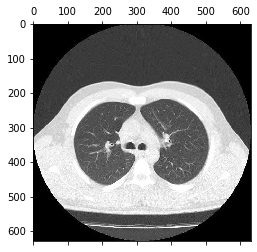

In [6]:
fig, ax = plt.subplots(1)
ax.matshow(x[70], cmap='gray')

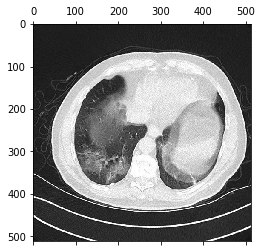

In [93]:
fig, ax = plt.subplots(1)
ax.matshow(array_to_img(x_train[150]), cmap='gray')

(512, 512, 1)


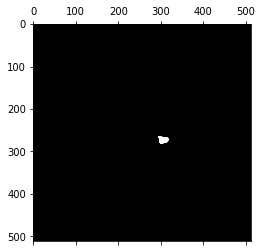

In [115]:
fig, ax = plt.subplots(1)
print(y_train[138].shape)
ax.matshow(array_to_img(y_train[138]), cmap='gray')


In [118]:
y_train = np.where(y_train >= 0.5, 1, 0)
y_test = np.where(y_test >= 0.5, 1, 0)

print(np.unique(y_train[138]))

[0 1]


In [119]:
batch_size = 32
seed = 1
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=1)

data_gen_args = dict(featurewise_center=True,
                     featurewise_std_normalization=True,
                     rotation_range=10,
                     horizontal_flip = True)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

image_datagen.fit(x_train, augment=True, seed=seed)
mask_datagen.fit(y_train, augment=True, seed=seed)

image_generator = image_datagen.flow(x_train, batch_size=batch_size, seed=seed)
mask_generator = mask_datagen.flow(y_train, batch_size=batch_size, seed=seed)

train_generator = zip(image_generator, mask_generator)

val_gen_args = dict()

image_datagen_val = ImageDataGenerator(**val_gen_args)
mask_datagen_val = ImageDataGenerator(**val_gen_args)

image_datagen_val.fit(x_val, seed=seed)
mask_datagen_val.fit(y_val, seed=seed)

image_generator_val = image_datagen_val.flow(x_val, batch_size=batch_size, seed=seed)
mask_generator_val = mask_datagen_val.flow(y_val, batch_size=batch_size, seed=seed)

val_generator = zip(image_generator_val, mask_generator_val)

In [120]:
from keras import backend as K
from keras.losses import binary_crossentropy


def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.cast(y_pred > t, dtype=tf.int32)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec))

def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

In [121]:
img_width = 512
img_height = 512
img_channels = 1

# build model
inputs = tf.keras.layers.Input((img_width, img_height, img_channels))

# contractive path
c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

# expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])

In [122]:
model.fit(train_generator, steps_per_epoch=x_train.shape[0]/batch_size, epochs=3, validation_data=val_generator,
          validation_steps=x_val.shape[0]/batch_size)

model.predict(x_test)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 15.0625 steps, validate for 1.6875 steps
Epoch 1/3
 1/15 [>.............................] - ETA: 9:54

InvalidArgumentError:  assertion failed: [`labels` out of bound] [Condition x < y did not hold element-wise:] [x (metrics/mean_io_u_5/confusion_matrix/control_dependency:0) = ] [0 0 0...] [y (metrics/mean_io_u_5/confusion_matrix/Cast_2:0) = ] [2]
	 [[{{node metrics/mean_io_u_5/confusion_matrix/assert_less/Assert/AssertGuard/else/_19/Assert}}]] [Op:__inference_distributed_function_23355]

Function call stack:
distributed_function
